# Predicting adjacency via "adjacency distance"

Recall that we call a tuple of puzzle pieces (P, Q) (order matters!) to be __left-right adjacent__ if when P is placed to the left of Q, P's right edge is adjacent to Q's left edge.


We compute the __left-right adjacency distance__ of a tuple (P,Q) as follows:

* Extract RE, the right edge of piece P (1 pixel width)
* Extract LE, the left edge of Piece Q (1 pixel width). 
* Compute the difference LE-RE. 
* Set the left-right adjacency distance of (P,Q) to be the euclidean norm || LE-RE||

We will use the (negative of the __left-right adjacency distance__ ) as a score to predict the adjacency of puzzle piece tuples (P,Q)

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import os

import pprint
import itertools
from collections import defaultdict

# generate random integer values
from random import seed
from random import randint
import numpy as np
#from pylab import array
from random import sample
import math

#pytorch modules
import torch
from torch.utils.data import Dataset, DataLoader, IterableDataset
from torchvision import transforms, utils

import sys
import Checking_adjacency_dataset as cad
%matplotlib inline
import seaborn as sns
from sklearn import metrics


Let us compute  the left-right adjacency distance of puzzle piece tuples for some datapoints from our custom dataset

## Loading the dataset and dataloader

In [2]:
my_root_dir = os.getenv("MY_ROOT_DIR")
my_sq_puzzle_piece_dim = 100
my_size_of_buffer = 500
my_model_dim = 100
my_batch_size = 10

In [3]:
my_adjacency_dataset = cad.AdjacencyDataset(my_root_dir, my_sq_puzzle_piece_dim, 
                                        my_size_of_buffer, my_model_dim)

my_adjacency_dataloader = DataLoader(my_adjacency_dataset, my_batch_size)


Recall that a datapoint from our dataset looks like (crop(P+Q), label) where crop(P+Q) is a square piece of height = width = my_model_dim cropped from (P juxtaposed to the left of Q) containing the right edge of P and the left edge of Q in the middle



_NB - We will always ensure my_model_dim is even_

Since width of crop(P+Q) = my_model_dim and the labels of cols of crop(P+Q) vary from 0 to my_model_dim-1, the right edge of P is the column with label (my_model_dim//2)-1 while the left edge of Q is the column with label (my_model_dim//2)




We give below a function to display edge extraction (a thickened edge is extracted for illustration. In actuality, we will extract edges of width 1 px)

In [4]:
def display_edge_extraction(juxtaposed_pieces_torchtensor, width):
    #batchsize x channel x height x width
    check = width % 2
    assert (check==0), "Model dim is not even"
    
    #Get the first piece in a batch
    piece = juxtaposed_pieces_torchtensor[0, :, :, :]
    
    #Extract left and right edges around middle of width 10px
    thickened_right_edge = piece[:,:,(width//2)-10:(width//2)]
    thickened_left_edge = piece[:,:,(width//2):(width//2)+10]

    #Display the extracted edges
    my_dpi = 100
    fig = plt.figure(dpi = my_dpi)
    
    print(f"Piece of size {piece.size()}")
    piece_image = transforms.ToPILImage()(piece)
    ax=fig.add_subplot(222)
    ax.imshow(piece_image)
    ax.title.set_text('Piece')
    plt.axis('off')

    print(f"Thickened right edge of size {thickened_right_edge.size()}")
    ax=fig.add_subplot(223)
    right_edge_image = transforms.ToPILImage()(thickened_right_edge)
    ax.imshow(right_edge_image)
    ax.title.set_text('Right edge')
    plt.axis('off')


    print(f"Thickened left edge of size {thickened_left_edge.size()}")
    ax=fig.add_subplot(224)
    left_edge_image = transforms.ToPILImage()(thickened_left_edge)
    ax.imshow(left_edge_image)
    ax.title.set_text('Left edge')
    plt.axis('off')
    
    fig.tight_layout()
    plt.show()
    print("*****************")
    
    

Piece of size torch.Size([3, 100, 100])
Thickened right edge of size torch.Size([3, 100, 10])
Thickened left edge of size torch.Size([3, 100, 10])


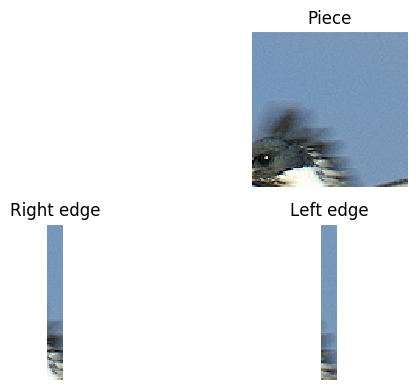

*****************
Piece of size torch.Size([3, 100, 100])
Thickened right edge of size torch.Size([3, 100, 10])
Thickened left edge of size torch.Size([3, 100, 10])


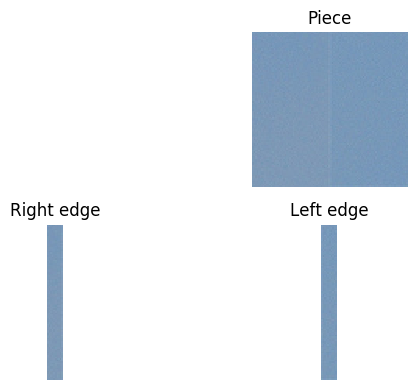

*****************


In [5]:
counter = 0
for juxtaposed_pieces_torchtensor, label in my_adjacency_dataloader:
    (display_edge_extraction(juxtaposed_pieces_torchtensor, my_model_dim))
    counter += 1
    if counter > 1:
        break



The following code computes the adjacency distances from a batch of cropped images (of the shape crop(P+Q))

In [6]:
def adjacency_dist(juxtaposed_pieces_torchtensor, width):
    #juxtaposed_pieces_torchtensor = batchsize x channel x height x width
    check = width % 2
    assert (check==0), "Model dim is not even"
    right_edges = juxtaposed_pieces_torchtensor[:, :, :, (width//2)-1]
    left_edges = juxtaposed_pieces_torchtensor[:, :, :, (width//2)]
    differences = left_edges-right_edges
    distances = torch.norm(differences, p='fro', dim=(1,2))
    return distances
  

## Plot of adjacency distances vs labels

Total number of examples : 5000
No of adjacent (1) labels : 2285
No of non-adjacent (0) labels : 2715


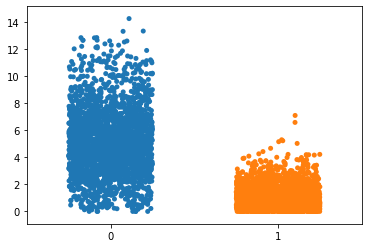

In [7]:
no_of_batches = 0
no_of_adjacent = 0
true_labels = []
negative_distance_scores = []

for juxtaposed_pieces_torchtensor, label in my_adjacency_dataloader:
    if no_of_batches >= 500:
        break
    distances = adjacency_dist(juxtaposed_pieces_torchtensor,  my_model_dim)
    true_labels.extend(list(map(lambda x: x.item(), label)))
    negative_distance_scores.extend(list(map(lambda x: -x.item(), distances)))
    group = np.array(label)
    no_of_adjacent += np.sum(group)
    values = np.array(distances)
    p = sns.stripplot(x=group,
                      y=values,
                      jitter=0.25)
    no_of_batches += 1


total_examples = no_of_batches*my_batch_size
no_of_non_adjacent = total_examples - no_of_adjacent
print(f"Total number of examples : {total_examples}")
print(f"No of adjacent (1) labels : {no_of_adjacent}")
print(f"No of non-adjacent (0) labels : {no_of_non_adjacent}")




We note that for this plot the edge dimensions are 3 x 100 and each pixel entry is between 0 and 1. Thus the difference matrix (left_edge - right_edge) has dimensions 3 x 100 with entries at most 1 and at least -1. So the maximum norm of the difference is bounded above by sqrt(300) which is ~ 17.3

Eyeballing the graph, we see that adjacent tuple pieces seem to mostly have an adjacency distance of atmost 4 (ignoring outliers). However the adjaceny distance of  non-adjacent tuple pieces seem to be spread out between 0 and sqrt(300) ..

# A binary classifier

In this no ML approach to checking adjacency, we would like to set a threshold distance __td__. We will then predict tuples with adjacency distance > _td_ to be non-adjacent and <= _td_ to be adjacent. 

## Computing statistics

We have already computed the negative of distance scores for 5000 puzzle-piece tuples above. Recall that this data is stored in the list _negative_distance_scores_. For these data-points, the actual labels (adjacent(1)/non-adjacent(0)) is stored in the list _true_labels_




We now compute the following metrics for a range of thresholds

* _False postive rate (fpr)_ : False positives/Total negatives
* _True positive rate (tpr)_  or Recall: True positives/Total positives
* _Accuracy_ : True positives + True negatives/Total number of examples
* _Precision_ : True positives/Predicted positives


We first plot the precision-recall curve



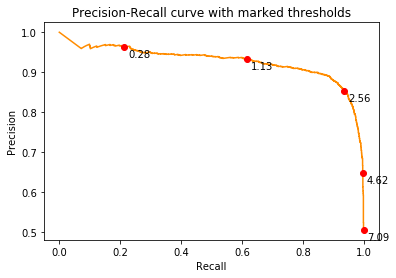

In [8]:
precision, recall, prthresholds = metrics.precision_recall_curve(true_labels,negative_distance_scores, pos_label=1)
plt.figure()
plt.plot(recall,precision, color='darkorange')

for x,y,t in list(zip(recall,precision,prthresholds))[1::1000]:
    label = "{:.2f}".format(-t)
    plt.plot(x,y,"ro")
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(15,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve with marked thresholds')
plt.show()


We now plot the ROC curve (fpr vs tpr)

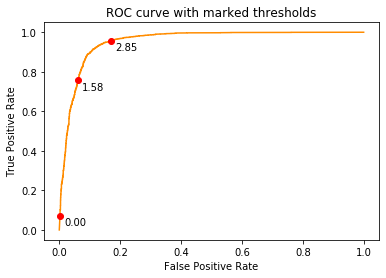

In [9]:
fpr, tpr, thresholds = metrics.roc_curve(true_labels, negative_distance_scores, pos_label=1)
plt.figure()
plt.plot(fpr, tpr, color='darkorange')

for x,y,t in list(zip(fpr,tpr,thresholds))[1::300]:
    label = "{:.2f}".format(-t)
    plt.plot(x,y,"ro")
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(15,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve with marked thresholds')
plt.show()

In [10]:
accuracy = (no_of_adjacent*tpr + (1.-fpr)*no_of_non_adjacent)/total_examples

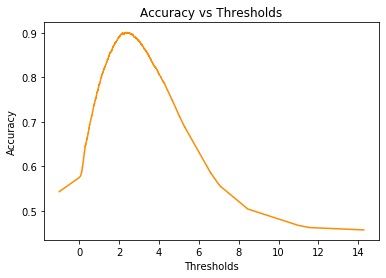

In [11]:
plt.figure()
plt.plot(-1*thresholds, accuracy, color='darkorange')


plt.xlabel('Thresholds')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Thresholds')
plt.show()

In [12]:
index_of_max_accuracy = np.argmax(accuracy)

In [13]:
threshold_for_best_accuracy = -thresholds[index_of_max_accuracy]
best_accuracy = accuracy[index_of_max_accuracy]


In [14]:
print(f"threshold_for_best_accuracy is {threshold_for_best_accuracy}")
print(f"best_accuracy is {best_accuracy}")

threshold_for_best_accuracy is 2.3586792945861816
best_accuracy is 0.901


We set our threshold _td_ = threshold_for_best_accuracy


Thus we predict (P,Q) to be left-right adjacent if adjacency_dist(P,Q) <= td and non-left-right-adjacent if not

## Some more statistics

In [15]:
negative_td= -1*threshold_for_best_accuracy
def f(score):
    if score > negative_td:
        return 1
    else:
        return 0
    
predicted_labels = list(map(f, negative_distance_scores))


In [16]:
# Confusion matrix
# The columns show the number of examples predicted for each label,
# The rows show the actual number of examples for each label.
print(metrics.confusion_matrix(true_labels, predicted_labels, labels=[1, 0]))

[[2090  195]
 [ 301 2414]]


In [17]:
# Other metrics
print(metrics.classification_report(true_labels, predicted_labels, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      2715
           1       0.87      0.91      0.89      2285

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000

